# Mapping Sea Ice Surface Topography With ICESat-2

Trys to reproduce ATL07 workflow

Uses tracks from [Farrel et al (2020)](https://agupubs.onlinelibrary.wiley.com/doi/abs/10.1029/2020GL090708)

![Farrel et al (2020) Figure 1]("images/farrell_grl61408-fig-0001-m.jpg")

Farrel et al (2020) use two granules:
| Date | RGT | Beam | Subsetted Region (lonmin, latmin, lonmax, latmax) |
|------|-----|------|---------------------------------------------------|
| 2019-04-22 | 03710304 | gt2l | `(-120., 79.5, -100., 83.)` |
| 2019-07-19 | 03570304 | gt2l | `(-160., 76.25, -140., 81)` |

I want to be able to do two tasks: search by ground track, cycle and segment number and extract results to a geopandas dataframe (ultimately stac catalog) to allow geospatial joins.

## TODO
- Get corresponding ATL07 files
- Get OIB underflight
- Find coincident Sentinel-1 granules
- Find coincident Sentinel-2 granules

## File Naming Convention

```
ATL03_[yyyymmdd][hhmmss]_[ttttccss]_[vvv_rr].h5
```

|Variable|Description|
|--------|-----------|
| `ATL03`  | Product short name |
| `yyyymmdd` | Year, month, and day of data acquisition |
| `hhmmss` | Data acquisition start time, hour, minute, and second (UTC) |
| `tttt` | Four-digit Reference Ground Track number. The ICESat-2 mission has 1,387 RGTs, numbered from 0001 to 1387. |
| `cc` | Cycle Number. Each of the 1,387 RGTs is targeted in the polar regions once every 91 days. The cycle number tracks the number of 91-day periods that have elapsed since ICESat-2 entered the science orbit. |
| `ss` | Segment number. ATL03 data files are segmented into approximately 1/14th of an orbit. Segment numbers range 01–14. Note that some segments may not be available. |
| `vvv` | Version |
| `rr` | Revision number |

In [15]:
import sys
sys.path.append("../src")

from pprint import pprint

import earthaccess
import h5py
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np

from shapely.geometry import Polygon

import reader 
from plotting import _get_bbox

### Find and download granules

In [2]:
auth = earthaccess.login()

In [3]:
results0 = earthaccess.search_data(
    short_name="ATL03",
    # bounding_box=(-160., 65., -90., 90.),
    # temporal=("2019-04-22","2019-04-22"),
    version="006",
    granule_name="ATL03_??????????????_03710304_???_??.h5",
    cloud_hosted=False,
    )

results1 = earthaccess.search_data(
    short_name="ATL03",
    # bounding_box=(-160., 65., -90., 90.),
    # temporal=("2019-04-22","2019-04-22"),
    version="006",
    granule_name="ATL03_??????????????_03570304_???_??.h5",
    cloud_hosted=False,
    )

len(results0 + results1)

2

In [4]:
earthaccess.download(results0 + results1, local_path="../data")

QUEUEING TASKS | : 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 1313.39it/s]
PROCESSING TASKS | : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 11397.57it/s]
COLLECTING RESULTS | : 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18558.87it/s]


['../data/ATL03_20190422132750_03710304_006_02.h5',
 '../data/ATL03_20190421152747_03570304_006_02.h5']

### Plot search results

In [5]:
#proj = ccrs.Projection.from_proj4("+proj=stere +lat_0=90 +lat_ts=70 +lon_0=-45 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs")
proj = ccrs.Stereographic(central_latitude=90., central_longitude=-45., true_scale_latitude=70.)

In [6]:
# Define extent in projected coordinates
extent_ll = [(0., 75.), (100., 75.), (-170., 63.), (-110, 63.)]  # guessed from Fig 1a
xy = [proj.transform_point(*ll, ccrs.PlateCarree()) for ll in extent_ll]
xx, yy = list(zip(*xy))
extent_xy = [np.array(xx).min(), np.array(xx).max(), np.array(yy).min(), np.array(yy).max()]

In [7]:
# Set graticule
xlocs = np.arange(0.,360,30.) - 180.
ylocs = [85., 80., 75., 70., 65., 60., 55., 50.]

In [10]:
# Get bounding box for results and create shapely geometry
bbox_xy = [proj.transform_point(*ll, ccrs.PlateCarree()) for ll in _get_bbox(results0[0])]

TypeError: Value after * must be an iterable, not Polygon

In [ ]:
region_a = [-120., 79.5, -100., 83.]


In [ ]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_axes(111, projection=proj)
ax.set_extent(extent_xy, proj)

# ax.add_geometries([bbox], proj)
ax.add_geometries(_get_bbox(results0[0]), proj)

ax.plot([region_a[i] for i in [0,0,2,2,0]], [region_a[j] for j in [1,3,3,1,1]], transform=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAND)
ax.gridlines(xlocs=xlocs, ylocs=ylocs)

# x = ds.lon_ph[::1000]
# y = ds.lat_ph[::1000]
# ax.plot(x, y, ls='', marker='.', ms=.5, c='red', transform=ccrs.PlateCarree())

ax.add_geometries(_get_bbox(iocam1b_results[0]), ccrs.PlateCarree(), zorder=5)

### Read data from ATL03 onto `pandas.DataFrame`

In [11]:
filepath = "../data/ATL03_20190422132750_03710304_006_02.h5"
beam = "gt2l"

In [ ]:
# df = reader.atl03(filepath, beam)
# df

In [85]:
f = h5py.File(filepath)

photon_height = f[f"{beam}/heights/h_ph"][:]
photon_delta_time = f[f"{beam}/heights/delta_time"][:]  # convert to time
photon_latitude = f[f"{beam}/heights/lat_ph"][:]
photon_longitude = f[f"{beam}/heights/lon_ph"][:]
photon_quality = f[f"{beam}/heights/quality_ph"][:]
photon_signal_confidence = f[f"{beam}/heights/signal_conf_ph"][:]
photon_along_track_distance = f[f"{beam}/heights/dist_ph_along"][:]
photon_across_track_distance = f[f"{beam}/heights/dist_ph_across"][:]
photon_pulse_id = f[f"{beam}/heights/ph_id_pulse"][:]
photon_count_id = f[f"{beam}/heights/ph_id_count"][:]

# Geolocation
photon_index_begin = f[f"{beam}/geolocation/ph_index_beg"][:]  # 1-based index of first photon in segment 
segment_photon_count = f[f"{beam}/geolocation/segment_ph_cnt"][:]  # count of photons in segment
segment_distance_x = f[f"{beam}/geolocation/segment_dist_x"][:]  # along-track distance from equator to first photon

# Geophysical corrections
ocean_tide = f[f"{beam}/geophys_corr/tide_ocean"][:]
lpe_tide = f[f"{beam}/geophys_corr/tide_equilibrium"][:]
dem_height = f[f"{beam}/geophys_corr/dem_h"][:]

f.close()

# Geolocation segments have the 1-based index of the first photon 
# and the number of photons in each segment.  Missing values
# for this are 0 (zero) and applied when no suitable photon is found.
# See ATL03 ATBD.  This is the catch these occurances but we do not have
# a solution to deal with this here.  It may be a case of just dropping
# those segments.
if (photon_index_begin < 1).any():
    raise ValueError("Photon index less than one")
    
df_seg = pd.DataFrame({
    "photon_index_begin": photon_index_begin,
    "segment_photon_count": segment_photon_count,  # may not be needed
    "segment_distance_x": segment_distance_x,
    "ocean_tide": ocean_tide,
    "lpe_tide": lpe_tide,
    "dem_height": dem_height,
}, index=photon_index_begin-1)
# Used for error checking.  Dropped once checks performed
df_seg["sum_segment_photon_count"] = df_seg["segment_photon_count"].cumsum()

df = pd.DataFrame({
    "height": photon_height,
    "delta_time": photon_delta_time,
    "latitude": photon_latitude,
    "longitude": photon_longitude,
    "quality": photon_quality,
    "land_signal_confidence": photon_signal_confidence[:,0],
    "ocean_signal_confidence": photon_signal_confidence[:,1],
    "seaice_signal_confidence": photon_signal_confidence[:,2],
    "landice_signal_confidence": photon_signal_confidence[:,3],
    "inland_water_signal_confidence": photon_signal_confidence[:,4],
    "dist_ph_along": photon_along_track_distance,
    "photon_pulse_id": photon_pulse_id,
    "photon_count_id": photon_count_id,
})

# Check that total segment photon count equals number of photons
if df_seg["segment_photon_count"].sum() != len(df):
    raise RuntimeError("Total segment photon count exceeds number of photons!")

# Merge photon-rate and segment rate DataFrames
# Forward-fill missing values in segment-rate columns
df_all = pd.concat([df, df_seg], axis=1).ffill()

# Check that filling is correct by seeing if index is less than cumulative photon count
if not (df_all.index < df_all["sum_segment_photon_count"]).all():
    raise RuntimeError("Mismatch between photon and segment indices")

df_all.drop("sum_segment_photon_count", inplace=True, axis=1)

# Create along-track distance from equator
df_all["ph_dist_x"] = df_all["dist_ph_along"] + df_all["segment_distance_x"]

df_all

,height,delta_time,latitude,longitude,quality,land_signal_confidence,ocean_signal_confidence,seaice_signal_confidence,landice_signal_confidence,inland_water_signal_confidence,dist_ph_along,photon_pulse_id,photon_count_id,photon_index_begin,segment_photon_count,segment_distance_x,ocean_tide,lpe_tide,dem_height,ph_dist_x
0,3.432944,4.117487e+07,79.999864,-115.885232,0,-1,4,4,-1,-1,0.373568,141,1,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938309e+06
1,1.387273,4.117487e+07,79.999864,-115.885233,0,-1,1,1,-1,-1,0.384113,141,1,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938309e+06
2,3.350036,4.117487e+07,79.999864,-115.885232,0,-1,4,4,-1,-1,0.373992,141,1,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938309e+06
3,-2.882874,4.117487e+07,79.999871,-115.885241,0,-1,1,1,-1,-1,1.114284,142,1,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938310e+06
4,3.292497,4.117487e+07,79.999870,-115.885240,0,-1,4,4,-1,-1,1.082448,142,2,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938310e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16759714,1.079176,4.117518e+07,80.000080,85.543708,0,-1,4,4,-1,-1,18.517342,115,1,16759673.0,47.0,1.113280e+07,-0.071407,0.002303,0.564043,1.113282e+07
16759715,1.317137,4.117518e+07,80.000080,85.543708,0,-1,4,4,-1,-1,18.516130,115,1,16759673.0,47.0,1.113280e+07,-0.071407,0.002303,0.564043,1.113282e+07
16759716,-4.539921,4.117518e+07,80.000074,85.543700,0,-1,1,1,-1,-1,19.258265,116,1,16759673.0,47.0,1.113280e+07,-0.071407,0.002303,0.564043,1.113282e+07
16759717,1.142804,4.117518e+07,80.000068,85.543692,0,-1,4,4,-1,-1,19.941431,117,1,16759673.0,47.0,1.113280e+07,-0.071407,0.002303,0.564043,1.113282e+07


### Look at spread of heights in 5-shot aggregates

Following Duncan and Farrell

<Axes: >

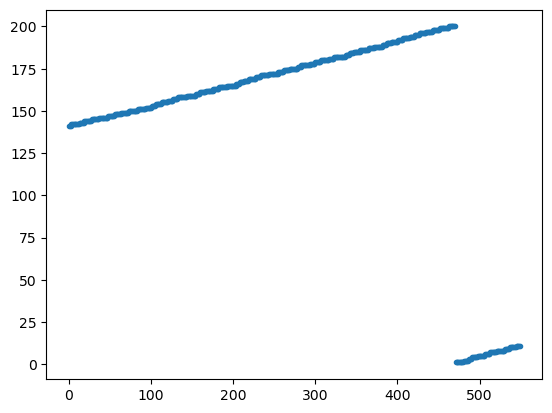

In [99]:
# Create unique pulse id
df_all[:550]["photon_pulse_id"].plot(ls='', marker='.')

### Create a continuous pulse-id

Photon pulse id (`ph_pulse_id`) in ATL03 count from 1 to 200 and then reset to 1.  To identify separate pulses, we need a continuous (not cyclic) pulse id.  This is done in `pandas` using a little magic.  First we identify the first photon in each pulse using the `series.shift` and `series.ne` (_not-equal_) methods.  This method compares the shifted series of photon pulse ids to find ids that do not match, which is the start of a run of the same pulse ids.  See [here](https://joshdevlin.com/blog/calculate-streaks-in-pandas/).

Next the `start` column is accumulated.  Although this is a boolean, True evaluates as 1 and False as 0 when summed.  This produces a continuous id.

We also want to identify groups of consecutive _five shot aggregates_.  This is done by using `series.floordiv` with a divisor of 5.

In [120]:
df_all["start"] = df_all.photon_pulse_id.ne(df_all.photon_pulse_id.shift())
df_all["streak_id"] = df_all["start"].cumsum()
df_all["five_shot_id"] = df_all["streak_id"].floordiv(5)
df_all.loc[:50,["photon_pulse_id", "streak_id", "five_shot_id"]]

,photon_pulse_id,streak_id,five_shot_id
0,141,1,0
1,141,1,0
2,141,1,0
3,142,2,0
4,142,2,0
5,142,2,0
6,142,2,0
7,142,2,0
8,142,2,0
9,142,2,0


In [129]:
df_all.five_shot_id.max()

590045

<Axes: >

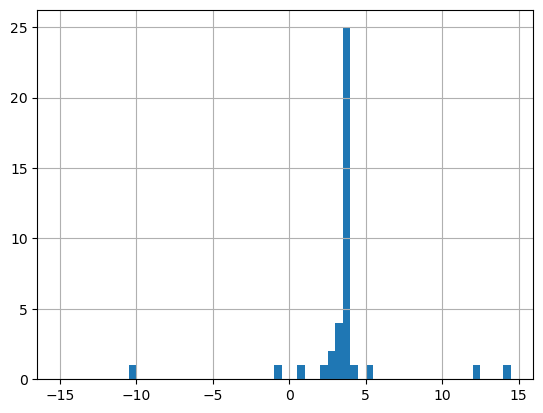

In [130]:
bins = np.arange(-15,15,0.5)
df_all.loc[df_all.five_shot_id == 2000].height.hist(bins=bins)

In [113]:
x = df_all[:60]["photon_pulse_id"].to_frame()
x["start"] = x.photon_pulse_id.ne(x.photon_pulse_id.shift())
x["streak_id"] = x["start"].cumsum()
x["five_shot"] = x["streak_id"].floordiv(5)
x

,photon_pulse_id,start,streak_id,five_shot
0,141,True,1,0
1,141,False,1,0
2,141,False,1,0
3,142,True,2,0
4,142,False,2,0
5,142,False,2,0
6,142,False,2,0
7,142,False,2,0
8,142,False,2,0
9,142,False,2,0


### Apply sea ice and ocean specific corrections

Corrections for solid earth tides, solid earth pole tides, ocean pole tides, ocean loading, and atmospheric range delays have been applied to photon heights (`h_ph`) as part of ATL03 processing (ATBD section 6.0).  For sea ice and ocean applications, ocean tides, longperiod ocean tides, and dynamic atmospheric corrections must also be applied.

Following the ATL07 ATBD, corrections for sea ice are

$$
h_{gc} = h_{ph} - h_{MSS} - h_{ocean tide} - h_{lpe tide} - h_{IB DYN}
$$

where $h_{MSS}$ is mean sea level, $h_{ocean tide}$ is ..., $h_{lpe tide}$ is long period ocean tide, and $h_{IBDYN}$ is the inverted barometer dynamic correction.  This returns a height referenced to mean sea level.

$$
h_{IBDYN} =  \frac{-9.948(met\_slp-oce\_slp)}{1000}
$$

_Add description of corrections from ATL07 ATBD.  May have to check with Alek._

In [49]:
# Geophysically corrected height relative to geoid without dynamic inverted barometer
df_all["h_gc"] = df_all["height"] - df_all["ocean_tide"] - df_all["lpe_tide"]

In [30]:
def confidence(x):
    conf = {
        # -2: "tab:red",
        # -1: "tab:pink",
        # 0: "tab:purple",
        # 1: "tab:blue",
        # 2: "tab:cyan",
        # 3: "tab:olive",
        # 4: "tab:green",
        -2: "r",
        -1: "m",
        0: "y",
        1: "g",
        2: "c",
        3: "b",
        4: "k",
    }
    return conf[x]

In [25]:
df_test = pd.DataFrame({
    "sea_ice_signal_confidence": [-2, 4, 4, 3, 2, 1, 0, -1]
})
df_test.map(confidence)
                       

,sea_ice_signal_confidence
0,tab:red
1,tab:green
2,tab:green
3,tab:olive
4,tab:cyan
5,tab:blue
6,tab:purple
7,tab:pink


<Axes: xlabel='segment_distance_x'>

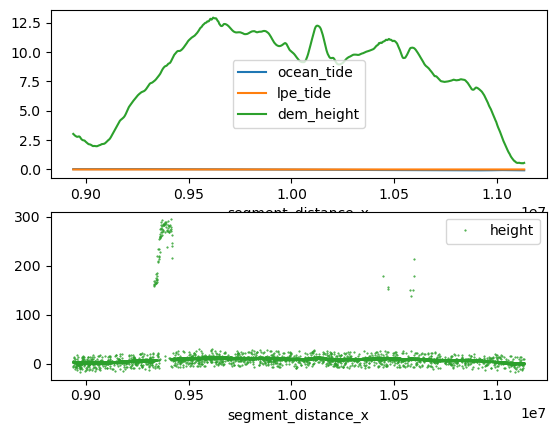

In [46]:
fig, ax = plt.subplots(2, 1)

df_all.loc[::1000].plot(x="segment_distance_x", y=["ocean_tide", "lpe_tide", "dem_height"], ax=ax[0])
df_all.loc[::1000].plot(x="segment_distance_x", y=["height"], 
                        ax=ax[1], ls='', marker='.', ms=1, alpha=1,
                        color=df_all["seaice_signal_confidence"].map(confidence))

### Signal quality and confidence

To demonstrate working with the data, we will first subset the data to the region used in Farrel et al.

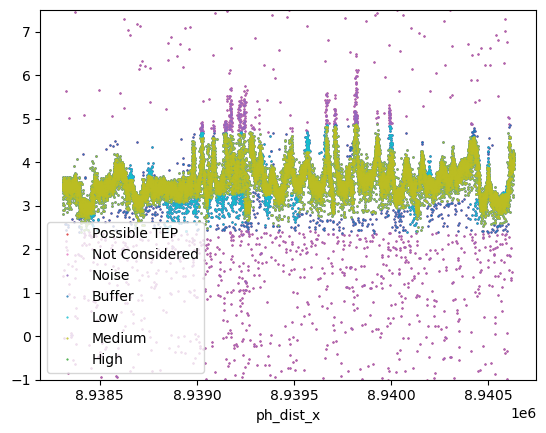

In [34]:
df_sub = df_all[:25000]

fig, ax = plt.subplots()
ax.set_ylim(-1,7.5)

# df_all["height"].where(df_all["seaice_signal_confidence"] < 4)[:25000].plot(ls='',marker='.',ms=1, c="red", alpha=0.6, ax=ax)
# df_all["height"].where(df_all["seaice_signal_confidence"] > 3)[:25000].plot(ls='',marker='.',ms=1, c="k", alpha=0.6, ax=ax) #color=df_all["seaice_signal_confidence"].map(confidence))
for thresh, color, label in zip([-2,-1,0,1,2,3,4],
                         ["tab:red","tab:pink","tab:purple","tab:blue",
                          "tab:cyan","tab:olive","tab:green"],
                         ["Possible TEP", "Not Considered", "Noise",
                          "Buffer", "Low", "Medium", "High"]):
    df_sub.where(df_sub["seaice_signal_confidence"] > thresh).plot(x="ph_dist_x", y="height",
            ls='',marker='.',ms=1, c=color, 
            alpha=1., ax=ax, label=label)

<Axes: xlabel='ph_dist_x'>

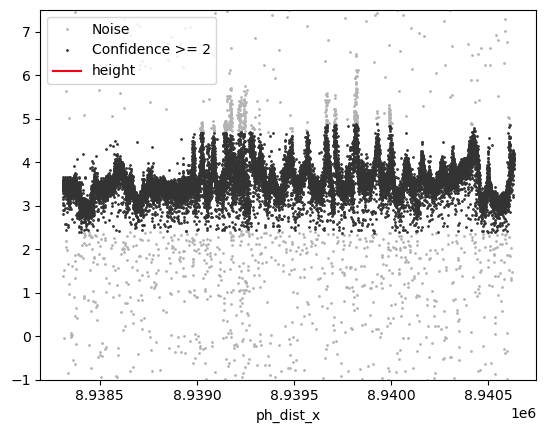

In [52]:
thresh = 2

fig, ax = plt.subplots()
ax.set_ylim(-1,7.5)

df_sub.where(df_sub["seaice_signal_confidence"] < thresh).plot(x="ph_dist_x", y="height",
            ls='',marker='.',ms=2, c='0.7', 
            alpha=1., ax=ax, label="Noise")

df_sub.where(df_sub["seaice_signal_confidence"] >= thresh).plot(x="ph_dist_x", y="height",
            ls='',marker='.',ms=2, c='0.2', 
            alpha=1., ax=ax, label=f"Confidence >= {thresh}")

window=150
rolling = df_sub.where(df_sub["seaice_signal_confidence"] > thresh).rolling(window=window, center=True)
rolling.mean().plot(x="ph_dist_x", y="height", ax=ax, color="red")

In [54]:
dfr = df_sub.where(df_sub["seaice_signal_confidence"] > thresh)
dfr

,height,delta_time,latitude,longitude,quality,land_signal_confidence,ocean_signal_confidence,seaice_signal_confidence,landice_signal_confidence,inland_water_signal_confidence,dist_ph_along,photon_index_begin,segment_photon_count,segment_distance_x,ocean_tide,lpe_tide,dem_height,ph_dist_x
0,3.432944,4.117487e+07,79.999864,-115.885232,0.0,-1.0,4.0,4.0,-1.0,-1.0,0.373568,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938309e+06
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.350036,4.117487e+07,79.999864,-115.885232,0.0,-1.0,4.0,4.0,-1.0,-1.0,0.373992,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938309e+06
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.292497,4.117487e+07,79.999870,-115.885240,0.0,-1.0,4.0,4.0,-1.0,-1.0,1.082448,1.0,219.0,8.938309e+06,0.029486,0.002250,3.029798,8.938310e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,4.208116,4.117487e+07,80.020195,-115.910504,0.0,-1.0,4.0,4.0,-1.0,-1.0,1.716928,24979.0,226.0,8.940630e+06,0.029556,0.002251,2.998664,8.940632e+06
24996,4.117126,4.117487e+07,80.020195,-115.910504,0.0,-1.0,4.0,4.0,-1.0,-1.0,1.717394,24979.0,226.0,8.940630e+06,0.029556,0.002251,2.998664,8.940632e+06
24997,3.929392,4.117487e+07,80.020195,-115.910504,0.0,-1.0,4.0,4.0,-1.0,-1.0,1.718361,24979.0,226.0,8.940630e+06,0.029556,0.002251,2.998664,8.940632e+06
24998,4.158629,4.117487e+07,80.020195,-115.910504,0.0,-1.0,4.0,4.0,-1.0,-1.0,1.717179,24979.0,226.0,8.940630e+06,0.029556,0.002251,2.998664,8.940632e+06


<Axes: xlabel='ph_dist_x'>

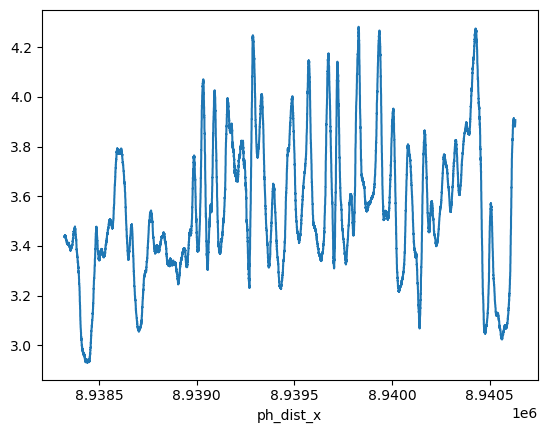

In [60]:
heights = dfr.dropna().set_index("ph_dist_x")["height"]
heights.rolling(150).mean().plot()

<Axes: >

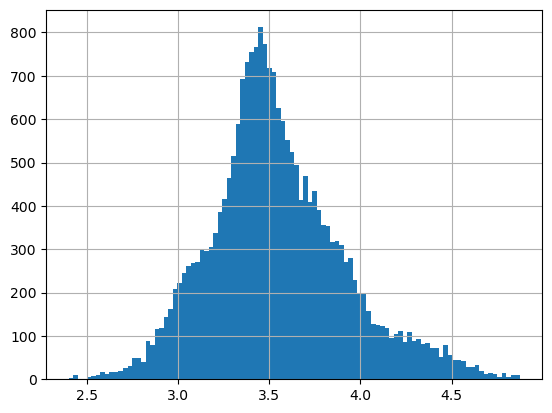

In [67]:
heights.hist(bins=100)

In [72]:
x0 + n*step

np.float64(8939309.23686458)

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

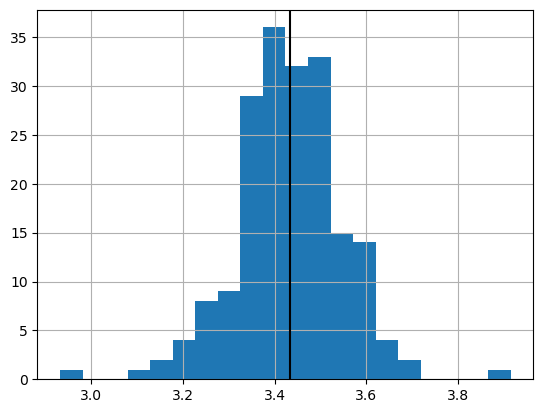

In [83]:
x0 = heights.index[0]
n = 3
step = 20
x1 = x0 + (n-1)*step
x2 = x0 + n*step
h = heights.loc[(heights.index > x1) & (heights.index <= x2)]

fig, ax = plt.subplots()
h.hist(bins=20, ax=ax)
ax.axvline(h.mean(), c='k')
ax.axvline(h.mode(), c='k', ls='--')


### Plot Data


In [128]:
iocam1b_results = earthaccess.search_data(
    short_name="IOCAM1B",
    temporal=("2019-04-22","2019-04-22"),
)
#f = earthaccess.open(result[0])

In [131]:
_get_bbox(iocam1b_results[0])

[<POLYGON ((-115.016 81.412, -114.92 81.407, -114.875 81.425, -114.971 81.431...>]

### Subsetting the data

A common task is subsetting the data to a region defined by latitude and longitude.  Normaly, we would use the indexing methods for `xarray`.  However, 

In [16]:
ds_sub = ds.where(((ds.lat_ph > 79.5) & (ds.lat_ph < 83.)
                   & (ds.lon_ph > -120) & (ds.lon_ph < -100)).compute(), drop=True)
ds_sub

<xarray.Dataset> Size: 193MB
Dimensions:         (delta_time: 2298916, ds_surf_type: 5)
Coordinates:
  * delta_time      (delta_time) datetime64[ns] 18MB 2019-04-22T13:27:50.3266...
    lat_ph          (delta_time) float64 18MB 80.0 80.0 80.0 ... 82.5 82.5 82.5
    lon_ph          (delta_time) float64 18MB -115.9 -115.9 ... -120.0 -120.0
Dimensions without coordinates: ds_surf_type
Data variables:
    dist_ph_across  (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    dist_ph_along   (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    h_ph            (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    pce_mframe_cnt  (delta_time) float64 18MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    ph_id_channel   (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    ph_id_count     (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    ph_id_pulse     (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    quality_ph      (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
    signal_conf_ph  (delta_time, ds_surf_type) float32 46MB dask.array<chunksize=(2298916, 5), meta=np.ndarray>
    weight_ph       (delta_time) float32 9MB dask.array<chunksize=(2298916,), meta=np.ndarray>
Attributes:
    Description:  Contains arrays of the parameters for each received photon.
    data_rate:    Data are stored at the photon detection rate.

### Plotting Data

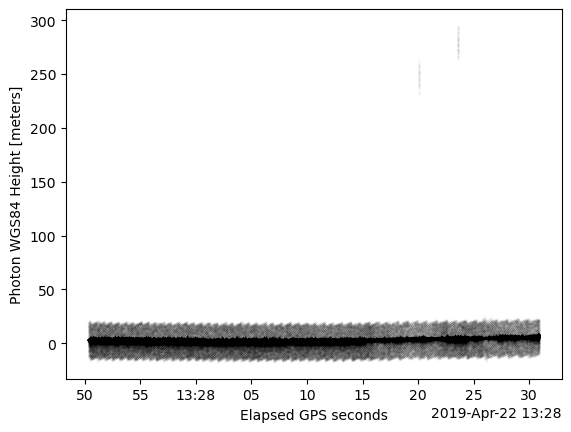

In [26]:
ds_sub.h_ph.plot(ls='', marker='.', ms=.2, c='k', alpha=0.1)

In [36]:
pprint(results[0]["meta"], indent=4)

{   'collection-concept-id': 'C2596864127-NSIDC_CPRD',
    'concept-id': 'G2681610092-NSIDC_CPRD',
    'concept-type': 'granule',
    'format': 'application/iso:smap+xml',
    'native-id': 'ATL03_20190422005840_03630305_006_02.h5',
    'provider-id': 'NSIDC_CPRD',
    'revision-date': '2023-05-08T21:16:46.204Z',
    'revision-id': 2}


In [37]:
pprint(results[0]["umm"], indent=4)

{   'CollectionReference': {   'EntryTitle': 'ATLAS/ICESat-2 L2A Global '
                                             'Geolocated Photon Data V006'},
    'DataGranule': {   'ArchiveAndDistributionInformation': [   {   'Name': 'Not '
                                                                            'provided',
                                                                    'Size': 3050.811912536621,
                                                                    'SizeUnit': 'NA'}],
                       'DayNightFlag': 'Unspecified',
                       'Identifiers': [   {   'Identifier': 'ATL03_20190422005840_03630305_006_02.h5',
                                              'IdentifierType': 'ProducerGranuleId'}],
                       'ProductionDateTime': '2023-04-10T01:49:10.000Z'},
    'GranuleUR': 'ATL03_20190422005840_03630305_006_02.h5',
    'MetadataSpecification': {   'Name': 'UMM-G',
                                 'URL': 'https://cdn.earthdata.nasa

In [ ]:
earthacess.ipx.subset

results = icepyx.subset()

icepyx.open(results, variables=icepyx.variables("ATL03"))

But...

In [ ]:
earthaccess.hmy.subset()

Both `xarray` and `geopandas` allow variables to be dropped or not loaded.  So load just a subset of variables.

In [138]:
dir(_get_bbox(results[0])[0])

['__and__',
 '__bool__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__geo_interface__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__or__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__sub__',
 '__subclasshook__',
 '__xor__',
 '_geom',
 '_geom_prepared',
 '_ndim',
 '_repr_svg_',
 'almost_equals',
 'area',
 'boundary',
 'bounds',
 'buffer',
 'centroid',
 'contains',
 'contains_properly',
 'convex_hull',
 'coords',
 'covered_by',
 'covers',
 'crosses',
 'difference',
 'disjoint',
 'distance',
 'dwithin',
 'envelope',
 'equals',
 'equals_exact',
 'exterior',
 'from_bounds',
 'geom_type',
 'geometryType',
 'has_z',
 'hausdorff_distance',
 'interiors',
 'interpolate',
 'intersection',
 'intersects',
 'is_closed',
 'is_empty',
 'is_rin

In [ ]:
import numpy as np

df1 = pd.DataFrame({
    "height": 